<table style="width :100%;">
    <td style="width : 7.5%;">
        <img style="float: left;
                width: 75px;"
         src="https://upload.wikimedia.org/wikipedia/fr/d/d9/Logo_T%C3%A9l%C3%A9com_ParisTech.svg" />
    </td>
    <td style="width : 15%;">
        TELECOM PARIS<br />2021/2022<br /><br /> IA702<br />Mme Anne Sabourin
    </td>
    <td>
        <h1><center>PROBABILISTIC MODELS & MACHINE LEARNING<br /><br />TP2 : La Segmentation d'image</center></h1>
    </td>
    <td style="width : 12.5%;">
        Alexandre ROULEAU <br />Date TP : 2021/10/06<br /><br /> Date CR : 2021/10/24<br /> Version : 0
    </td>
</table>    

<hr>
<h1>1. La segmentation bayésienne d'image</h1>
<hr>
<h2>1.1. Imports des packages/librairies/modules Python</h2>

In [1]:
import cv2 as cv
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt   
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import seaborn as sns

from math import log2, sqrt
from scipy.stats import norm
from sklearn.cluster import KMeans

<h2>1.2. Imports de fonctions Python prédéfinies</h2>

In [2]:
import utils
help(utils)

Help on module utils:

NAME
    utils

FUNCTIONS
    MAP_MPM2(Y, cl1, cl2, p1, p2, m1, sig1, m2, sig2)
    
    bruit_gauss2(X, cl1, cl2, m1, sig1, m2, sig2)
    
    calc_probaprio2(X, cl1, cl2)
    
    get_line_index(dSize)
        Cette fonction permet d'obtenir l'ordre de parcours des pixels d'une image carrée selon un parcours ligne par ligne
        :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction ne fonctionne qu'avec des images carrées)
        :return: une liste de taille 2*dSize*dSize qui correspond aux coordonnées de chaque pixel ordonnée selon le parcours ligne par ligne
    
    get_peano_index(dSize)
        Cette fonction permet d'obtenir l'ordre de parcours des pixels d'une image carrée (dont la dimension est une puissance de 2)
        selon la courbe de Hilbert-Peano
        :param dSize: largeur ou longueur de l'image en pixel (peu importe, la fonction de fonctionne qu'avec des images carrées)
        :return: une liste de taille 2*dSi

<h2>1.3. Récupération de scripts utilisés dans la partie 1</h2>

In [3]:
def OPENPICTURE(FileName=[]):
    MAINDir = os.getcwd() + '\\images'
    PICTList = [f for f in listdir(MAINDir) if isfile(join(MAINDir, f))]
    PICTExt = '.bmp'
    if not FileName:
        FILEfind = False
        df = pd.DataFrame({'FileName' : PICTList}, index = np.arange(len(PICTList))+1)
        print(df)
        while FILEfind == False :
            FILEselected = str(input('\nEntrer le nom (avec/sans .bmp) ou numéro de fichier à ouvrir : '))
            try :
                int(FILEselected)
            except ValueError:
                if not PICTExt in FILEselected:
                    FILEselected += PICTExt
                if FILEselected in PICTList:
                    FILEfind = True
            else :
                FILEselected = int(FILEselected)
                if 0<FILEselected and FILEselected<len(PICTList):
                    FILEselected = PICTList[FILEselected-1]
                    FILEfind = True
    else :
        FILEselected = FileName + PICTExt
    X = cv.cvtColor(cv.imread(MAINDir + '\\' + FILEselected),cv.COLOR_BGR2GRAY)
    #X = cv.imread(MAINDir + '\\' + FILEselected)
    counts, _ = np.histogram(X, bins=int(X.max()+1), range=(0,int(X.max())))
    Cl1, Cl2 = np.nonzero(counts)[0]
    
    return X, Cl1, Cl2

In [4]:
def pltfigure (fig, Img, Title, isubplot, Subtitle, Params=[], Terreur=[]):
    
    print (isubplot)
    
    if isubplot == 0:
        fig.suptitle(str(Title))
        botrig=plt.subplot(4,3,1)
        botrig.set_axis_off()
        plt.imshow(X,cmap='Greys')
        
        botrig = plt.subplot(4,3,3)
        botrig.clear()
        botrig.set_axis_off()
        #plt.title("Image d'origine")
        plt.text(1,
             1,"IMAGE D'ORIGINE",
             horizontalalignment='right',
             verticalalignment='top',
             fontsize=6)
        
    else:
        botrig=plt.subplot(4,3,1+3*isubplot)
        botrig.set_axis_off()
        plt.imshow(Img[0],cmap='Greys')
        
        botrig=plt.subplot(4,3,2+3*isubplot)
        botrig.set_axis_off()
        plt.imshow(Img[1],cmap='Greys')
        
        botrig = plt.subplot(4,3,3+3*isubplot)
        botrig.clear()
        botrig.set_axis_off()
        plt.text(1,
             1,str(Subtitle),
             horizontalalignment='right',
             verticalalignment='top',
             fontsize=6)
        plt.text(1,
             0,str(Params),
             horizontalalignment='right',
             verticalalignment='bottom',
             fontsize=6)
        plt.text(0,
             0.5,"Erreur : "+ str(np.round(Terreur,2))+"%",
             horizontalalignment='left',
             verticalalignment='bottom',
             fontsize=6)
    return fig

In [5]:
def init_param_em_inde(Y):
    kmeans = KMeans(n_clusters=2, random_state=0).fit(Y.reshape(-1,1))
    KMlabels = kmeans.labels_
    p1 = np.sum(KMlabels)/len(KMlabels)
    p2 = 1-p1
    m1 = np.sum(np.multiply(Y,(KMlabels)))/np.sum(KMlabels)
    m2 = np.sum(np.multiply(Y,(1 - KMlabels)))/np.sum(1 - KMlabels)
    sig1 = np.sum(np.multiply((Y - m1)**2, KMlabels))/np.sum(KMlabels)
    sig2 = np.sum(np.multiply((Y - m1)**2, 1- KMlabels))/np.sum(1 - KMlabels)
    return p1, p2, m1, m2, sig1, sig2, kmeans, KMlabels

<hr>
<h1>2. PARTIE II :Modèle de chaîne de Markov cachées</h1>
<hr>
<h2>2.1. Question 1 : $[f] = gauss2 (Y,n,\mu_1, \sigma_1,\mu_2, \sigma_2)$</h2>

In [6]:
def gauss2(Y,m1,sig1,m2,sig2):
    Mat_f = np.zeros((len(Y),2))
    Mat_f[:,0] = norm.pdf(Y, m1, np.sqrt(sig1))
    Mat_f[:,1] = norm.pdf(Y, m1, np.sqrt(sig2))
    return Mat_f

<h2>2.2. Question 2 : $forward2 ([f],A,p10,p20)$</h2>

In [7]:
def forward2(Mat_f,A,p10,p20):
    n, i = Mat_f.shape
    a = np.zeros((n,2))
    a[0,0] = p10 * Mat_f[0,0]
    a[0,1] = p20 * Mat_f[0,1]
    a[0,:] = a[0,:] / np.sum(a[0,:])
    for i in range(1,n):
        a[i,:] = a[i-1,:] @ A * Mat_f[i,:]
        a[i,:] = a[i,:]/np.sum(a[i,:])
    return a

<h2>2.3. Question 3 : $backward2([f],A)$</h2>

In [8]:
def backward2(Mat_f,A):
    n, i = Mat_f.shape
    beta = np.zeros((n,2))
    beta[0,:] = np.array([1, 1])
    beta[0,:] = beta[0,:]/np.sum(beta[0,:])
    Mat_f_flip = np.flip(Mat_f, 0)
    for k in range(1,n):
        beta[k,:] = A @ (beta[k-1,:]  * Mat_f_flip[k-1,:])
        beta[k,:] = beta[k,:]/np.sum(beta[k,:])
    beta = np.flip(beta, 0)
    return beta

<h2>2.4. Question 4: $MPM$ $chaines2([f],n,Cl1,Cl2,A,p_{10},p_{20})$</h2>

In [9]:
def MPM_chaines2(Mat_f, Cl1, Cl2, A, p10, p20):
    
    Alpha = forward2(Mat_f,A,p10,p20)
    Beta = backward2(Mat_f,A)
    
    Eups1 = Alpha[:,0] * Beta[:,0]
    Eups2 = Alpha[:,1] * Beta[:,1]
    
    X_apost = np.where((Eups1 > Eups2),Cl1,Cl2)
    return X_apost

<h2>2.5. Question 5: $calc$ $probaprio$ $mc(Y,Cl1,Cl2)$</h2>

In [10]:
def calc_probaprio_mc(Y): 
    p1, p2, m1, m2, sig1, sig2, kmeans, KMlabels = init_param_em_inde(Y)
    A = np.zeros([2,2])
    prev,lbl1 = KMlabels[0], np.sum(KMlabels)
    lbl0 = len(Y) - lbl1 
    for l in KMlabels[1:] :
        ij = np.where(prev == 0,
                      np.where(l==prev,[0,0,lbl0], [0,1,lbl0]),
                      np.where(l!=prev,[1,0,lbl1], [1,1,lbl1]))
        A[ij[0]][ij[1]]+=1/ij[2]
        prev = l
    return A, p1, p2, m1, sig1, m2, sig2

<h2>2.6. Question 6: $estim$ $param$ $EM$ $mc(iter, Y, A, p_{10}, p_{20},\mu_1, \sigma_1, \mu_2, \sigma_2)$</h2>

In [11]:
def estim_param_EM_mc(iter, Y, A, p10, p20, m1, sig1, m2, sig2):
    n = len(Y)
    EMA, EMp1, EMp2, EMm1, EMsig1, EMm2, EMsig2 = A, p10, p20, m1, sig1, m2, sig2
    
    for i in range (iter):
        Mat_f = gauss2(Y,EMm1,EMsig1,EMm2,EMsig2)
        alpha = forward2(Mat_f,EMA,EMp1,EMp2)
        beta = backward2(Mat_f,EMA)
        
        psi1 = alpha[:-1,0] * EMA[0,0] * Mat_f[1:,0] * beta[1:,0]
        psi2 = alpha[:-1,0] * EMA[0,1] * Mat_f[1:,1] * beta[1:,1]
        psi3 = alpha[:-1,1] * EMA[1,0] * Mat_f[1:,0] * beta[1:,0]
        psi4 = alpha[:-1,1] * EMA[1,1] * Mat_f[1:,1] * beta[1:,1]
        summ = psi1 + psi2 + psi3 + psi4

        psi1 = psi1 / summ
        psi2 = psi2 / summ
        psi3 = psi3 / summ
        psi4 = psi4 / summ
        
        epsi1 = alpha[:,0] * beta[:,0]
        epsi2 = alpha[:,1] * beta[:,1]
        summ2 = epsi1 + epsi2

        epsi1 = epsi1 / summ2
        epsi2 = epsi2 / summ2
        
        EMp1 = np.sum(epsi1) / n
        EMp2 = np.sum(epsi2) / n
        
        EMm1 = np.sum(Y * epsi1) / np.sum(epsi1)
        EMm2 = np.sum(Y * epsi2) / np.sum(epsi2)
        
        EMsig1 = np.sum((Y - EMm1)**2 * epsi1) / np.sum(epsi1)
        EMsig2 = np.sum((Y - EMm2)**2 * epsi2) / np.sum(epsi2)
        
        EMA[0,0] = np.sum(psi1) / np.sum(epsi1[:-1])
        EMA[0,1] = np.sum(psi2) / np.sum(epsi1[:-1])
        EMA[1,0] = np.sum(psi3) / np.sum(epsi2[:-1])
        EMA[1,1] = np.sum(psi4) / np.sum(epsi2[:-1])

    return EMA, EMp1, EMp2, EMm1, EMsig1, EMm2, EMsig2

<h2>2.7. Question 7 : $Segmentation$ $image$ $mc$</h2>
<h3>Fonction de segmentation d'image</h3>

In [12]:
def Segmentation_image_mc(X, Cl1, Cl2, m1, sig1, m2, sig2, iter):
    
    Xline = utils.peano_transform_img(X)
    Yline = utils.bruit_gauss2(Xline, Cl1, Cl2, m1, sig1, m2, sig2)
    
    A, p1, p2, m1, sig1, m2, sig2 = calc_probaprio_mc(Yline)
    Yl2Im = utils.transform_peano_in_img(Yline, 256)

    A, EMp1, EMp2, EMm1, EMsig1, EMm2, EMsig2 = estim_param_EM_mc(10, Yline, A, p1, p2, m1, sig1, m2, sig2)
    
    Mat_f = gauss2(Yline, EMm1, EMsig1, EMm2, EMsig2)
    Sline = MPM_chaines2(Mat_f, Cl1, Cl2, A, EMp1, EMp2)
    Sl2Im = utils.transform_peano_in_img(Sline, 256)
    Terreur = utils.taux_erreur(Sline, Xline)
    return Terreur, Xline, Yline, Yl2Im, Sline, Sl2Im

<h3>Script de lancement</h3>

0
cible2 1
1
cible2 2
2
cible2 3
3
0
promenade2 1
1
promenade2 2
2
promenade2 3
3
0
zebre2 1
1
zebre2 2
2
zebre2 3
3


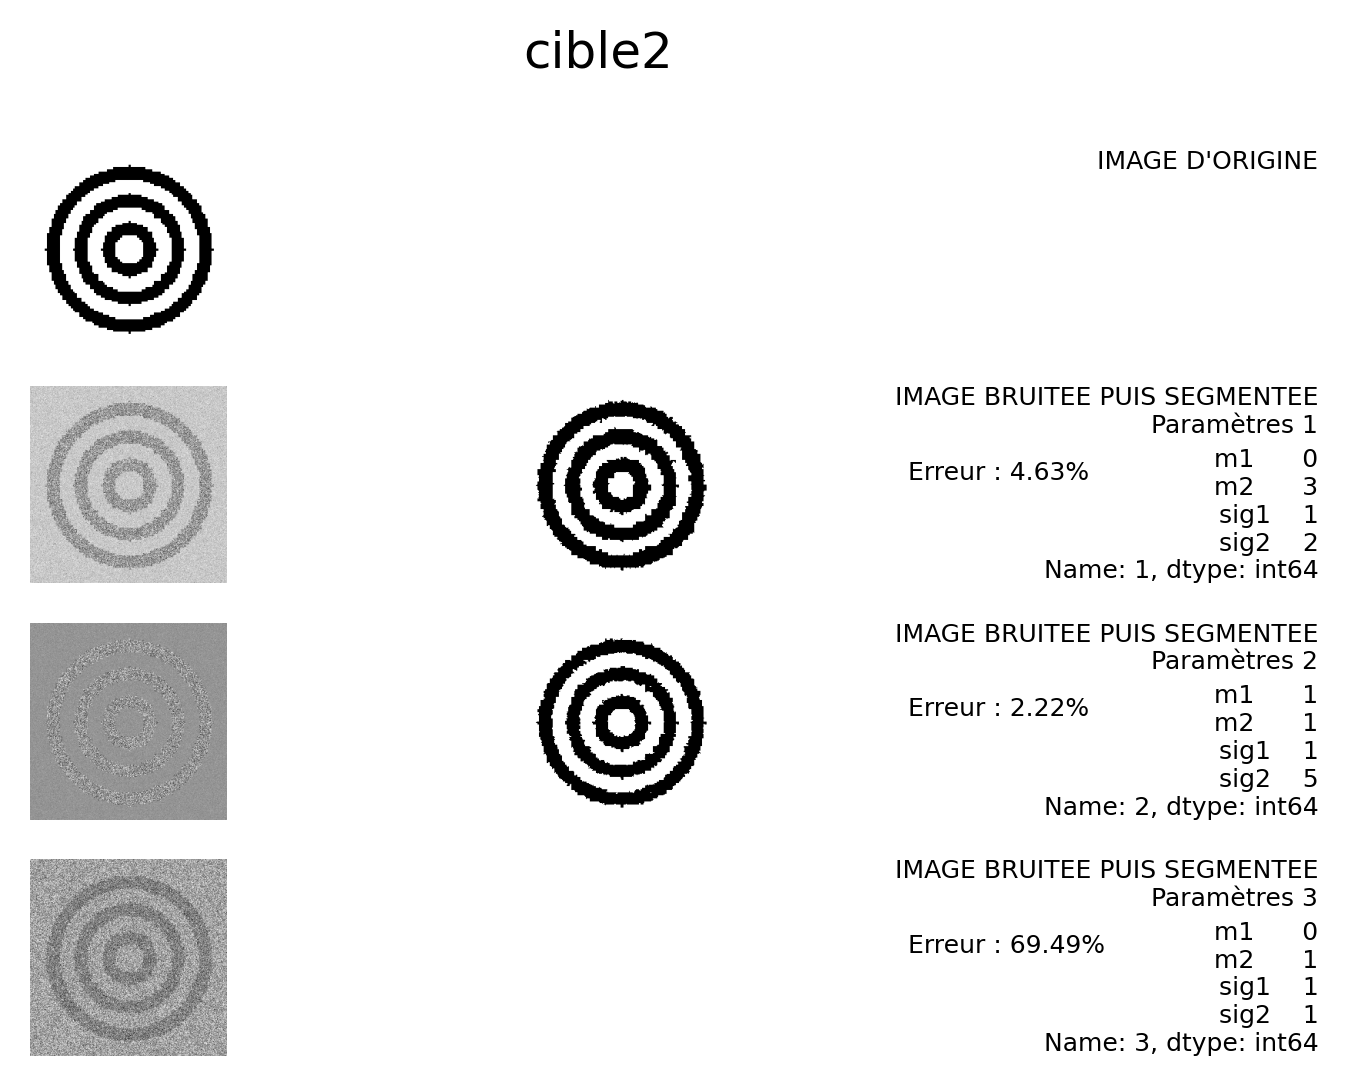

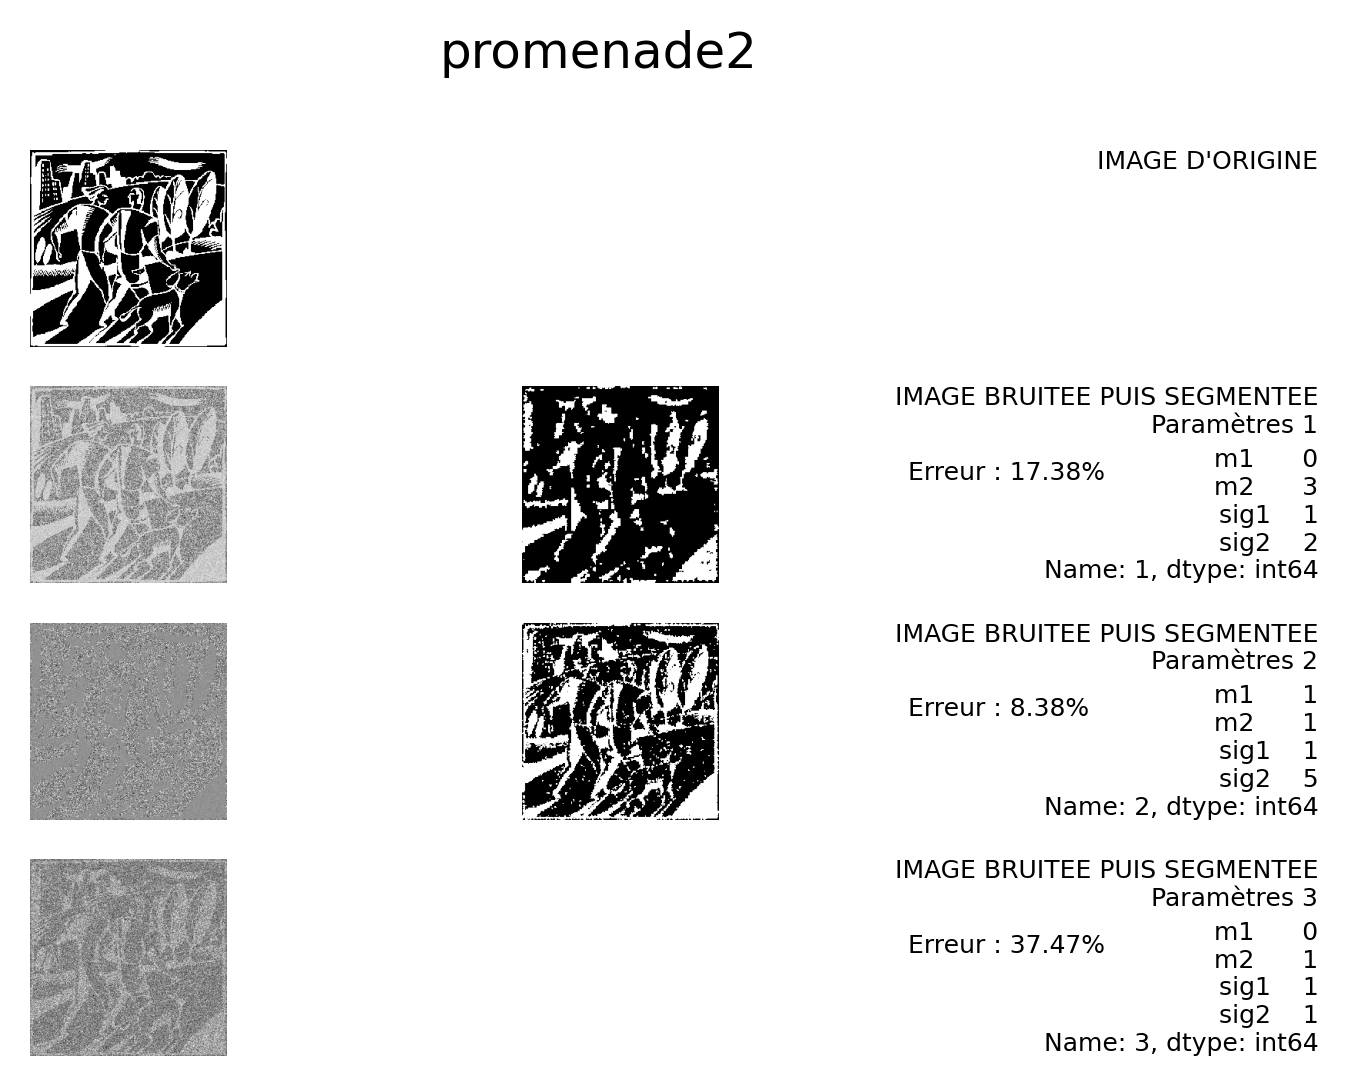

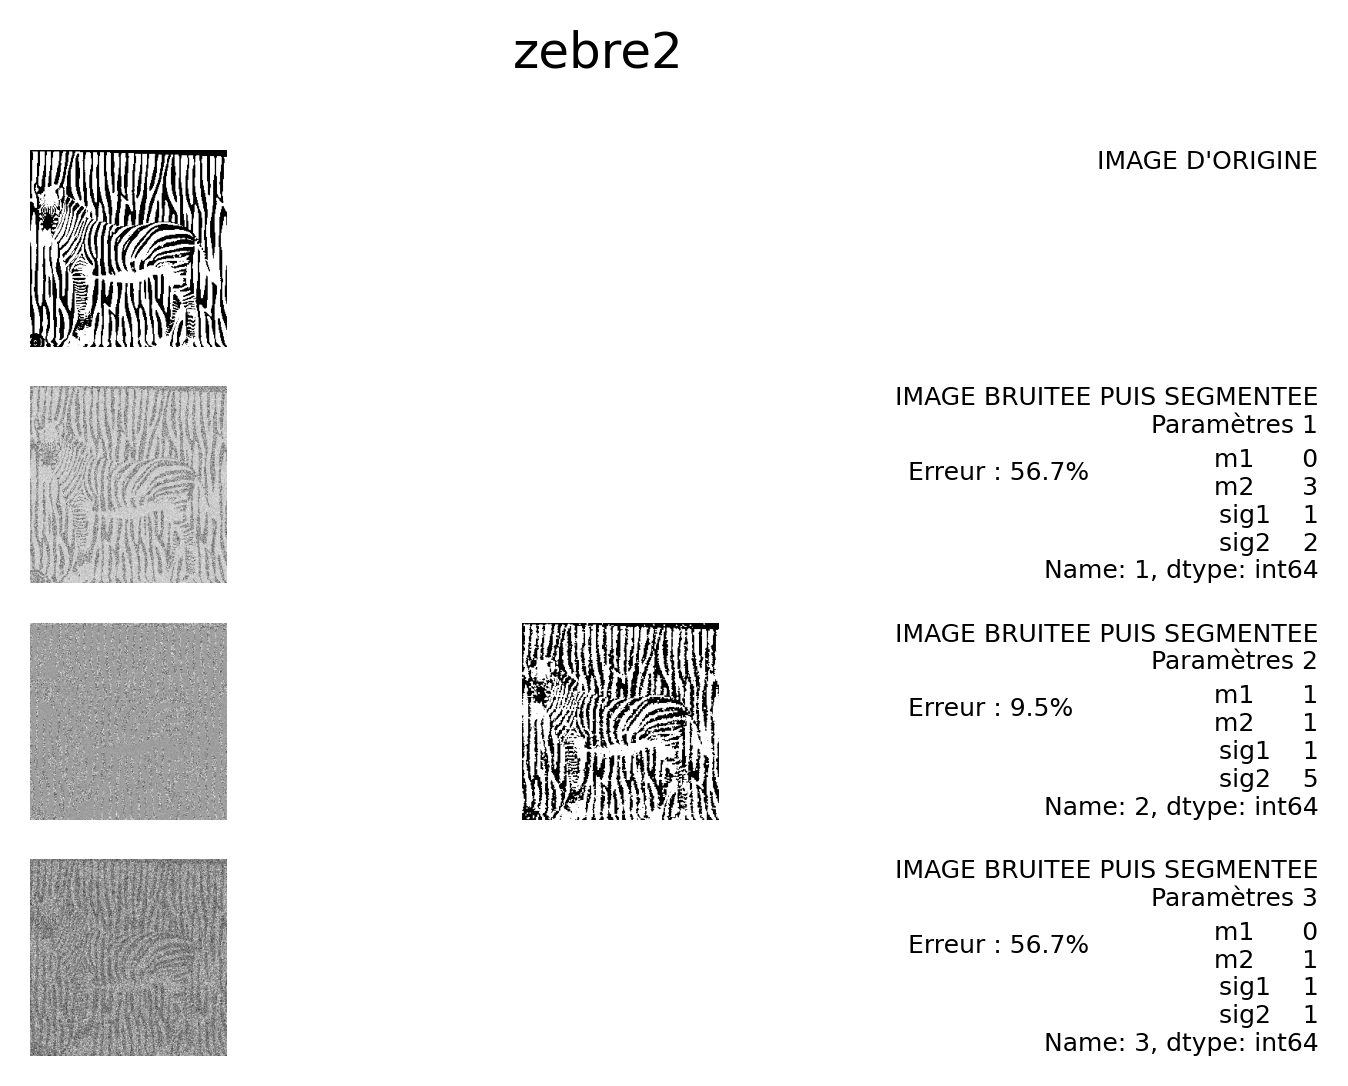

In [14]:
tab = []
image_seg = []
df_Params = pd.DataFrame({'m1':[0,1,0],
                          'm2':[3,1,1],
                          'sig1':[1,1,1],
                          'sig2':[2,5,1]},
                         index = np.arange(3)+1)
List3Img = ["cible2","promenade2","zebre2"]
iteration = 10
ifig=1
TABError = np.zeros([len(List3Img),len(df_Params)])
for iImg in List3Img:
    tab.append([])
    X,Cl1, Cl2 = OPENPICTURE(FileName = iImg)
    globals()['f'+str(ifig)]=plt.figure(dpi=300)
    pltfigure(globals()['f'+str(ifig)], X, iImg, 0, "IMAGE D'ORIGINE")
    isubplot = 1
    for iParams in df_Params.T:
        print(iImg, iParams)
        Terreur, Xline, Yline, YL2Im, S, Sl2Im = Segmentation_image_mc(X,Cl1, Cl2,
                                                                       df_Params.T[iParams]['m1'],
                                                                       df_Params.T[iParams]['sig1'],
                                                                       df_Params.T[iParams]['m2'],
                                                                       df_Params.T[iParams]['sig2'],
                                                                       10)
        """if Terreur > 0.5:
            Terreur = 1-Terreur"""
        pltfigure(globals()['f'+str(ifig)],
                  [YL2Im, Sl2Im],
                  iImg, isubplot,
                  "IMAGE BRUITEE PUIS SEGMENTEE\nParamètres " + str(isubplot),
                  Params = df_Params.T[iParams],
                  Terreur = Terreur*100)
        TABError[ifig-1][iParams-1] = Terreur*100
        isubplot += 1
    ifig+=1

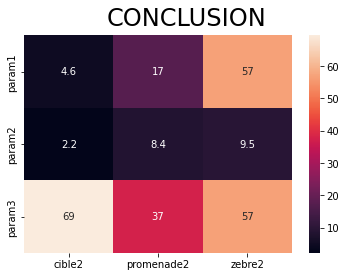

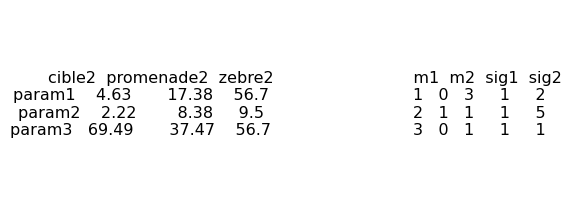

In [15]:
fig = plt.figure()
df_TabError = pd.DataFrame(TABError.T,
                           index = ['param1','param2','param3'],
                           columns=List3Img)
fig.suptitle('CONCLUSION',fontsize=24)
sns.heatmap(df_TabError, annot=True, vmin=np.min(df_TabError.values), vmax=np.max(df_TabError.values));


plt.figure(figsize=(8, 3))
botrig=plt.subplot(1,2,1)
botrig.clear()
botrig.set_axis_off()
plt.text(0, 0.5,
         str(np.round(df_TabError,2)),
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=16);

botrig=plt.subplot(1,2,2)
botrig.clear()
botrig.set_axis_off()
plt.text(1, 0.5,
         str(df_Params),
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=16);

plt.tight_layout()

Il est difficile de juger la qualité du traitement d'image. Je pense qu'il y a une erreur dans mon script. En effet, j'ai des sorties dont les pixels sont entièrement blanche (matrice remplie de 255).
Si toutefois le script s'est avéré exact, c'est alors lié :
- au random qui bruite l'image initial
- la procédure qui n'est adaptée qu'à condition de bien définir les paramètres de $\mu$ et de $\sigma$

Après comparaison des résultats avec mes collègues, certains rencontrent le même résultat (sortie entièrement noir, soit des matrice S rempli de 0). D'autres ont des sorties plus cohérentes avec un rendu différent en fonction des paramètres.

Parmi les images S dont les résultats sont davantages cohérents :
- le taux d'erreur est plus faible que la première partie (modèle des couples indépendants) - autour de 2 à 10%, soit un gain (ou plutôt une réduction du taux d'erreur) de 36 à 82%. Cette différence n'est pas négligeable.
- Même constat que la première partie : plus la répartition de noir et blanc est grande (exemple : le zèbre), plus le risque d'erreur est grand
- Dans la première méthode, on constate le taux d'erreur répartie dans toute l'image (forme de niveau de gris ajoutée à l'image initiale : des points dans les zones blanches, et inversement dans les zones noires).
- Ici, dans cette deuxième méthode, le taux d'erreur n'est pas "répartie dans toute l'image, mais plutôt au niveau des contours séparant le noir et le blanc. Les contours paraissent alors plus épais et/ou irréguliers.

Le résultat des images de sortie donne l'impression que le modèle de Markov consiste, à chaque itération, de chercher le pixel voisin dont sa valeur est la plus proche de celle de la couleur opposée afin de délimiter les contours de l'image. Ce qui pourrait expliquer les surépaisseur sur le rendu final.